### Installation and Imports

In [28]:
# %pip install --upgrade pip
# %pip install pandas
# %pip install numpy
# %pip install datetime
# %pip install collections
# %pip install matplotlib.pyplot
# %pip install seaborn
# %pip install pyyaml
# %pip install jsonlines
# %pip install requests
# %pip install datasets
# %pip install torch
# %pip install scikit-learn
# %pip install tabulate

In [29]:
import sys
import os
import json
import pandas as pd
import numpy as np
import ast
import itertools
import random
import copy
from datetime import datetime
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../")

from src.helpers import io
from src.classes.dataset import Dataset
from src.classes.annotation_set import AnnotationSet

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load datasets & annotations 

In [30]:
def get_wildchat_dataset():
    PATH_TO_DATASET = "../data/automatic_annotations_v0/wildchat4k-raw.json"
    DATASET_ID = "wildchat_1m"
    PATH_TO_ANNOTATIONS_DIR = "../data/automatic_annotations_v0/gpto3mini-json-wildchat"
    # Load dataset (w/o annotations)
    dataset = Dataset.load(PATH_TO_DATASET)

    # Load annotations into dataset
    for fpath in io.listdir_nohidden(PATH_TO_ANNOTATIONS_DIR):
        annotation_set = AnnotationSet.load_automatic(path=fpath, source="automatic_v0")
        dataset.add_annotations(annotation_set)
    return dataset

def get_hle_dataset():
    PATH_TO_DATASET = "../data/automatic_annotations_v0/hle-raw.json"
    DATASET_ID = "hle"
    PATH_TO_ANNOTATIONS_DIR = "../data/automatic_annotations_v0/hle"
    # Load dataset (w/o annotations)
    dataset = Dataset.load(PATH_TO_DATASET)

    # Load annotations into dataset
    for fpath in io.listdir_nohidden(PATH_TO_ANNOTATIONS_DIR):
        annotation_set = AnnotationSet.load_automatic(path=fpath, source="automatic_v0")
        dataset.add_annotations(annotation_set)
    return dataset

def get_mmlu_dataset():
    PATH_TO_DATASET = "../data/automatic_annotations_v0/mmlu-raw.json"
    DATASET_ID = "hle"
    PATH_TO_ANNOTATIONS_DIR = "../data/automatic_annotations_v0/mmlu"
    # Load dataset (w/o annotations)
    dataset = Dataset.load(PATH_TO_DATASET)

    # Load annotations into dataset
    for fpath in io.listdir_nohidden(PATH_TO_ANNOTATIONS_DIR):
        annotation_set = AnnotationSet.load_automatic(path=fpath, source="automatic_v0")
        dataset.add_annotations(annotation_set)
    return dataset

# Helper to split annotation keys if they are lists in string form
def split_annotation_key(key):
    try:
        # Try to parse as a Python list
        items = ast.literal_eval(key)
        if isinstance(items, list):
            a =[str(item).strip() for item in items if str(item).strip()]
            return a
        else:
            return [key]
    except Exception:
        return [key]

def aggregate_counts_by_category(annotation_pairs):
    category_counts = {}
    for key, count in annotation_pairs.items():
        categories = split_annotation_key(key)
        for cat in categories:
            if cat == '' or cat.lower() == 'none':
                continue
            category_counts[cat] = category_counts.get(cat, 0) + count
    return category_counts


In [31]:
wildchat_dataset = get_wildchat_dataset()
hle_dataset = get_hle_dataset()
mmlu_dataset = get_mmlu_dataset()

prompt-multi_turn_relationship: 0 / 10127 failed due to invalid annotations.
prompt-interaction_features: 0 / 10127 failed due to invalid annotations.
turn-sensitive_use_flags: 0 / 10127 failed due to invalid annotations.
turn-topic: 1 / 10127 failed due to invalid annotations.
response-interaction_features: 0 / 10127 failed due to invalid annotations.
prompt-function_purpose: 6 / 10127 failed due to invalid annotations.
prompt-media_format: 0 / 10127 failed due to invalid annotations.
response-media_format: 0 / 10127 failed due to invalid annotations.
response-answer_form: 0 / 10127 failed due to invalid annotations.
prompt-interaction_features: 1 / 1000 failed due to invalid annotations.
turn-sensitive_use_flags: 0 / 1000 failed due to invalid annotations.
turn-topic: 25 / 1000 failed due to invalid annotations.
prompt-function_purpose: 19 / 1000 failed due to invalid annotations.
prompt-media_format: 33 / 1000 failed due to invalid annotations.
prompt-interaction_features: 1 / 1000 

### Tree Map Plots Comparing WildChat to MMLU

In [32]:
import plotly.graph_objects as go
#import plotly.io as pio
#pio.renderers.default = "notebook" 

def plot_category_tree_plotly(category_counts, title, parent_dict):
    labels = []
    parents = []
    values = []
    # Replace commas in child labels with <br> for better display in Plotly
    def format_label(label):
        label = label.replace(',', '')
        label = label.replace('/', '')
        return label.replace(' ', '<br>')#.replace('&', '<br>&')

    # Prepare formatted parent_dict for label mapping (only format children)
    formatted_parent_dict = {parent: [format_label(child) for child in children] for parent, children in parent_dict.items()}

    # Use formatted labels for all further processing
    labels = []
    parents = []
    values = []

    # Build a reverse mapping from subcategory to parent (with formatted child labels)
    child_to_parent = {}
    for parent, children in formatted_parent_dict.items():
        for child in children:
            child_to_parent[child] = parent

    # Find which parents have at least one child in category_counts
    parents_with_children = set()
    for cat in category_counts:
        formatted_cat = format_label(cat)
        parent = child_to_parent.get(formatted_cat)
        if parent is not None:
            parents_with_children.add(parent)

    # Add only those parent nodes
    for parent in parents_with_children:
        labels.append(parent)
        parents.append('')
        values.append(0)

    # Add all categories in category_counts (children)
    for cat, count in category_counts.items():
        formatted_cat = format_label(cat)
        parent = child_to_parent.get(formatted_cat)
        if parent is not None:
            labels.append(formatted_cat)
            parents.append(parent)
            values.append(count)
        else:
            print(f"Warning: Category '{cat}' has no parent in parent_dict. Skipping it.")
        # else:
        #     print(f"Warning: Category '{cat}' has no parent in parent_dict. Skipping it.")

    # print("Labels:", labels)
    # print("Parents:", parents)
    # print("Values:", values)
    fig = go.Figure(go.Treemap(
        labels=labels,
        parents=parents,
        values=values,
        textinfo="label+percent entry",
    ))
    fig.update_traces(textfont_size=20)
    #fig.update_traces(textfont=dict(size=18, minsize=14))
    fig.update_layout(width=2000, height=1400)
  
    #fig.update_layout(title=title, margin=dict(t=50, l=25, r=25, b=25))
    return values, parents, labels, fig


parent_dict = {
    "Math, Science, Engineering, and Technology": [
        "Math & Sciences",
        "Technology, Software & Computing",
        "Non-software Engineering & Infrastructure",
         "Nature & Environment", 
    ],
    "Business, Finance, and Economics": [
        "Economics",
        "Business & Finances",
    ], 
    "Arts, Culture & Entertainment": [
        "Art & Design",
        "Culture",
        "Entertainment, Hobbies & Leisure",
        "Fantasy / Fiction / Fanfiction",
        "Literature & Writing",
        "Video Games",
        "Fashion & Beauty"
    ],
    "Society & Lifestyle": [
        "Food & Dining",
        "Travel & Tourism",
        "Lifestyle",
        "Sports",
        "Interpersonal Relationships & Communication",
        "Transportation"
    ],
    "Social Sciences & Humanities": [
        "History",
        "Linguistics & Languages",
        "Psychology, Philosophy & Human Behavior",
        "Religion & Spirituality",   
        "Geography", 
        "Education"
    ],
    "News, Politics, and Current Events": [
        "Politics & Elections",
        "Social Issues & Movements",
        "News & Current Affairs",
    ],
    "High-Stakes Decision Making:": [
        "Employment & Hiring",
        "Insurance & Social Scoring",
        "Law, Criminal Justice, Law Enforcement",
        "Housing", 
        "Immigration / Migration", 
        "Health & Medicine"
        ],
    "Adult & Sensitive Content": [
        "Adult & Illicit Content",         
    ],
    "AOther": ["Other", 
              "None"]
}

annotation_pairs1 = wildchat_dataset.get_annotation_distribution(
    "turn_topic",
    level="message",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)
annotation_pairs2 = hle_dataset.get_annotation_distribution(
    "turn_topic",
    level="message",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)
annotation_pairs3 = mmlu_dataset.get_annotation_distribution(
    "turn_topic",
    level="message",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)

datasets = {
    "WildChat": annotation_pairs1,
    "Humanity's Last Exam": annotation_pairs2,
    "MMLU": annotation_pairs3
}


for dataset_name, annotation_pairs in datasets.items():
    print(f"Processing dataset: {dataset_name}")
    agg_wc = aggregate_counts_by_category(annotation_pairs)
    values, parents, labels, fig = plot_category_tree_plotly(agg_wc, title=f"{dataset_name} Category Tree (Plotly)", parent_dict=parent_dict)
    fig.show()
    fig.write_image(f"../plots/{dataset_name.lower()}_category_tree_plotly.pdf", scale=2)



Processing dataset: WildChat


Processing dataset: Humanity's Last Exam


Processing dataset: MMLU


### Alternative Plots (Didn't Find Helpful But Shown for Completeness)

Processing source: WildChat
Processing source: Humanity's Last Exam


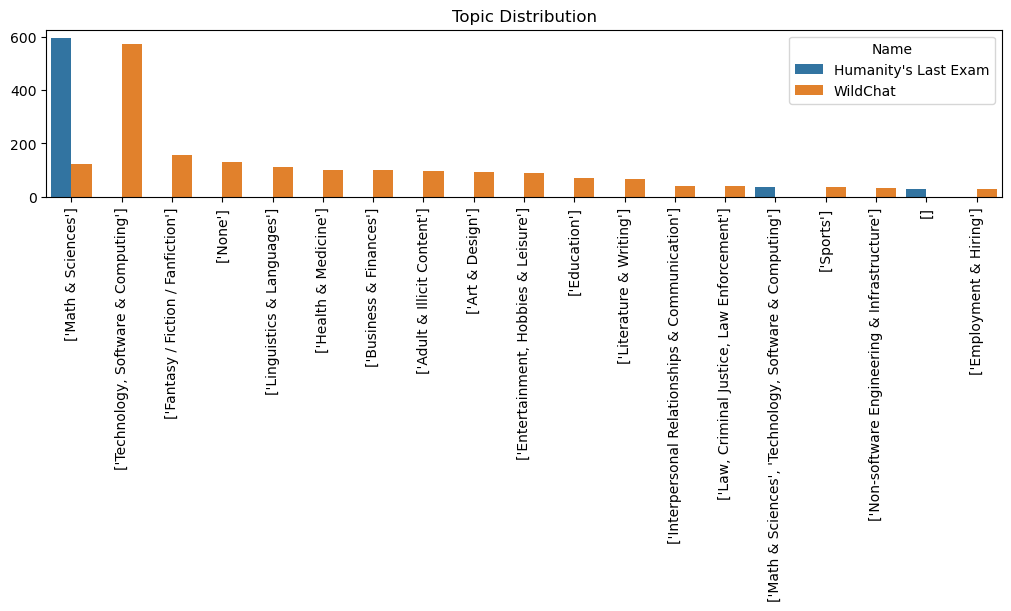

In [33]:
import pandas as pd 
import typing
import seaborn as sns 

xlabel = ""
ylabel = ""
title = ""
figsize =  (10, 6)
output_path= None,
order = "descending",
max_labels = 20
wildchat_dataset.data = wildchat_dataset.random_sample(1000)
annotation_pairs1 = wildchat_dataset.get_annotation_distribution(
    "turn_topic",
    level="message",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)
annotation_pairs2 = hle_dataset.get_annotation_distribution(
    "turn_topic",
    level="message",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)

normalize = False
data =  {"WildChat": annotation_pairs1, "Humanity's Last Exam": annotation_pairs2}
order = "ascending"


all_topics = []
all_counts = []
names = []
for source, distribution in data.items():
    print(f"Processing source: {source}")
    topics = list(distribution.keys())
    counts = list(distribution.values())
    all_topics.append(topics)
    all_counts.append(counts)
    names.append(source)


title = "Topic Distribution"
# Flatten the data from all_topics and all_counts
flattened_data = []
for i, source in enumerate(names):
    for topic, count in zip(all_topics[i], all_counts[i]):
        flattened_data.append({'Topic': topic, 'Count': count, 'Name': source})

# Create the DataFrame
df_topics = pd.DataFrame(flattened_data)

# Filter for the top 20 topics by count
df_topics = df_topics.sort_values(by='Count', ascending=False).head(20)

fig, ax = plt.subplots(figsize=figsize, layout='constrained')
sns.barplot(x='Topic', y='Count', hue='Name', data=df_topics, ax=ax)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_title(title)
ax.tick_params(axis='x', rotation=90)

# Limit the number of x-axis labels if needed
if len(ax.get_xticklabels()) > max_labels:
    # Keep only max_labels number of labels
    n_labels = len(ax.get_xticklabels())
    keep_indices = np.linspace(0, n_labels-1, max_labels, dtype=int)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticks([i for i in keep_indices])
    ax.set_xticklabels([labels[i] for i in keep_indices])
plt.show()

28 unique topics


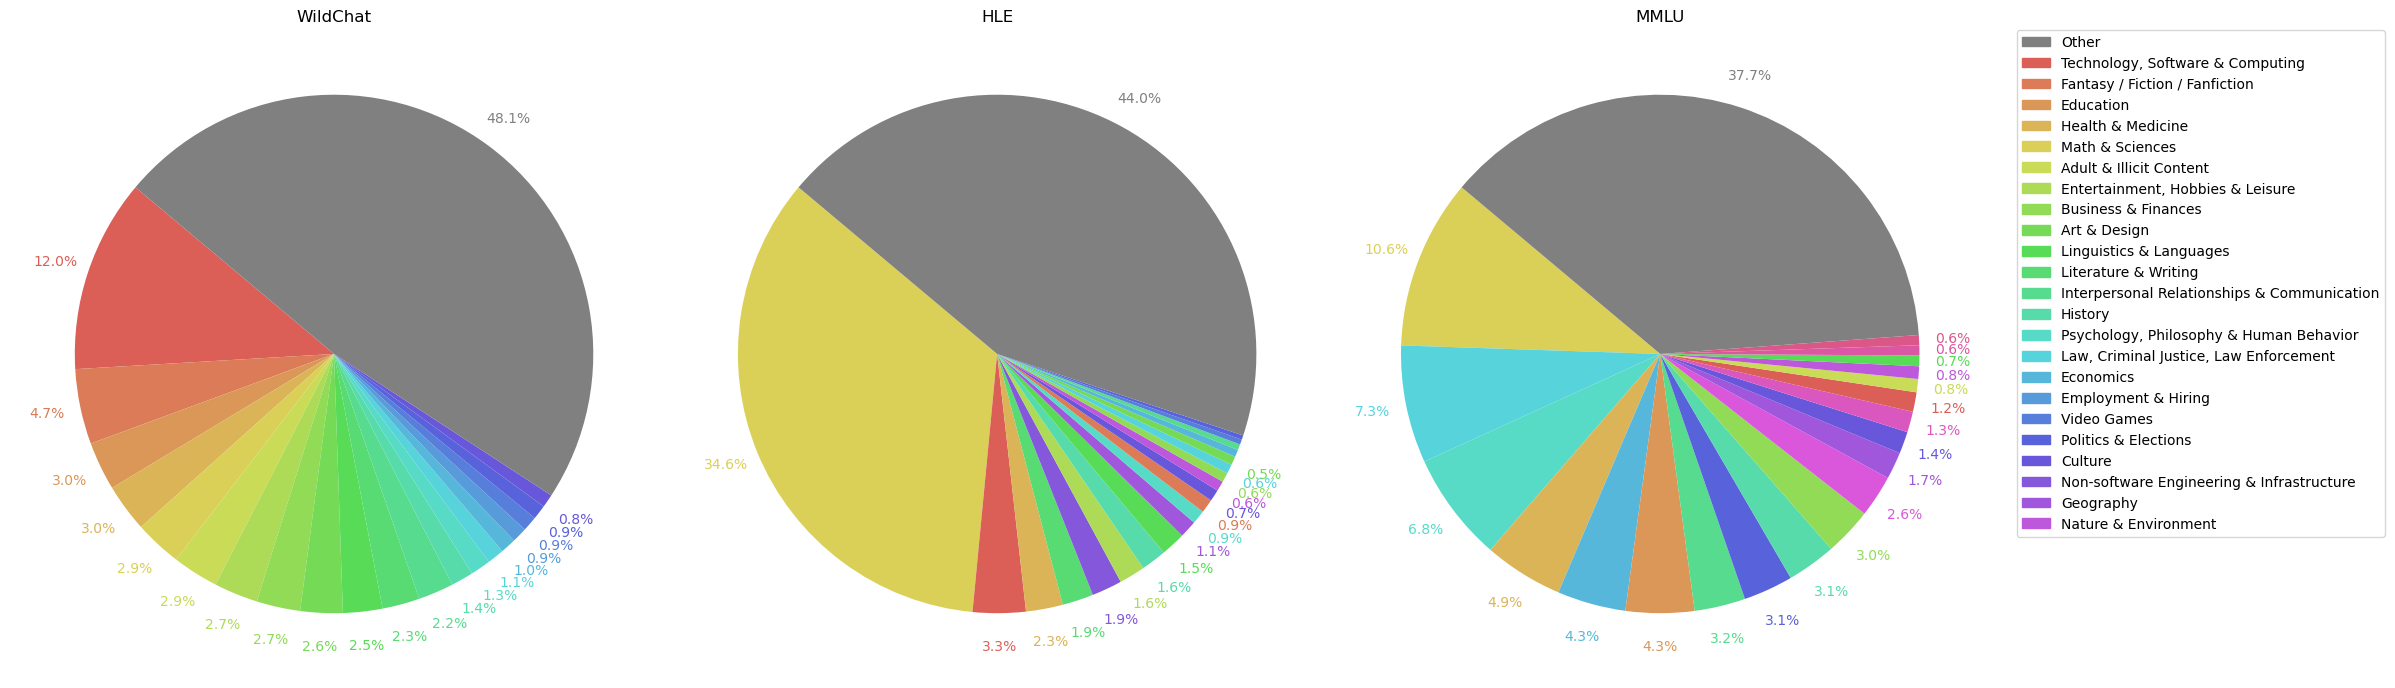

In [ ]:

def make_pie_chart(annotation_pairs1, annotation_pairs2, annoation_pairs_3, top_n = 20, aggregate_multilabel = True, percent_label_cut_off = 0.5):
    # Prepare data for pie charts
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    # Aggregate counts for both datasets
    if aggregate_multilabel:
        agg_wc = aggregate_counts_by_category(annotation_pairs1)
        agg_hle = aggregate_counts_by_category(annotation_pairs2)
        agg_mmlu = aggregate_counts_by_category(annoation_pairs_3)
    else: 
        agg_wc = annotation_pairs1
        agg_hle = annotation_pairs2
        agg_mmlu = annoation_pairs_3

    # Get top N categories for each
    top_wc = sorted(agg_wc, key=agg_wc.get, reverse=True)[:top_n]
    top_hle = sorted(agg_hle, key=agg_hle.get, reverse=True)[:top_n]
    top_mmlu = sorted(agg_mmlu, key=agg_mmlu.get, reverse=True)[:top_n]

    # Color map for topics, ensuring all colors are unique
    all_topics_set = list(dict.fromkeys(top_wc + top_hle + top_mmlu + ['Other']))  # preserve order, remove duplicates
    print(len(all_topics_set), "unique topics")
    palette = sns.color_palette("hls", n_colors=len(all_topics_set))
    color_map = {topic: palette[i] for i, topic in enumerate(all_topics_set)}
    color_map['Other'] = (0.5, 0.5, 0.5)  # assign grey to 'Other'

    # Define colors for the pie charts based on color_map and top topics
    colors_wc = [color_map.get(t, color_map['Other']) for t in top_wc] + [color_map['Other']]
    colors_hle = [color_map.get(t, color_map['Other']) for t in top_hle] + [color_map['Other']]
    colors_mmlu = [color_map.get(t, color_map['Other']) for t in top_mmlu] + [color_map['Other']]
    
    # Calculate "Other" for WildChat and HLE
    other_wc_count = sum([v for k, v in annotation_pairs1.items() if k not in top_wc])
    other_wc = pd.DataFrame({'Topic': ['Other'], 'Count': [other_wc_count]})

    other_hle_count = sum([v for k, v in annotation_pairs2.items() if k not in top_hle])
    other_hle = pd.DataFrame({'Topic': ['Other'], 'Count': [other_hle_count]})

    other_mmlu_count = sum([v for k, v in annoation_pairs_3.items() if k not in top_mmlu])
    other_mmlu = pd.DataFrame({'Topic': ['Other'], 'Count': [other_mmlu_count]})
    
    df_wc = pd.DataFrame({
        'Topic': top_wc + ['Other'],
        'Count': [agg_wc[t] for t in top_wc] + [other_wc['Count'].iloc[0]]
    })

    df_hle = pd.DataFrame({
        'Topic': top_hle + ['Other'],
        'Count': [agg_hle[t] for t in top_hle] + [other_hle['Count'].iloc[0]]
    })

    df_mmlu = pd.DataFrame({
        'Topic': top_mmlu + ['Other'],
        'Count': [agg_mmlu[t] for t in top_mmlu] + [other_mmlu['Count'].iloc[0]]
    })

    # Pie chart for WildChat
    wedges_wc, texts_wc, autotexts_wc = axes[0].pie(
        df_wc['Count'],
        labels=None,
        autopct=lambda pct: f'{pct:.1f}%' if pct > percent_label_cut_off  else '',
        startangle=140,
        colors=colors_wc[:len(df_wc)],
        pctdistance=1.13,
        labeldistance=1.25
    )
    axes[0].set_title('WildChat')

    # Set percent label color to match wedge color for WildChat
    for autotext, wedge in zip(autotexts_wc, wedges_wc):
        autotext.set_color(wedge.get_facecolor())

    # Pie chart for Humanity's Last Exam
    wedges_hle, texts_hle, autotexts_hle = axes[1].pie(
        df_hle['Count'],
        labels=None,
        autopct=lambda pct: f'{pct:.1f}%' if pct > percent_label_cut_off  else '',
        startangle=140,
        colors=colors_hle[:len(df_hle)],
        pctdistance=1.13,
        labeldistance=1.25
    )
    axes[1].set_title("HLE")

    # Pie chart for MMLU (put on the right, axes[2])
    wedges_mmlu, texts_mmlu, autotexts_mmlu = axes[2].pie(
        df_mmlu['Count'],
        labels=None,
        autopct=lambda pct: f'{pct:.1f}%' if pct > percent_label_cut_off else '',
        startangle=140,
        colors=colors_mmlu[:len(df_mmlu)],
        pctdistance=1.13,
        labeldistance=1.25
    )
    axes[2].set_title('MMLU')

    # Set percent label color to match wedge color for MMLU
    for autotext, wedge in zip(autotexts_mmlu, wedges_mmlu):
        autotext.set_color(wedge.get_facecolor())

    # Set percent label color to match wedge color for HLE
    for autotext, wedge in zip(autotexts_hle, wedges_hle):
        autotext.set_color(wedge.get_facecolor())
    
    # Set percent label color to match wedge color for MMLU
    for autotext, wedge in zip(autotexts_mmlu, wedges_mmlu):
        autotext.set_color(wedge.get_facecolor())
    
    # Make legend
    wc_count_map = {row['Topic']: row['Count'] for _, row in df_wc.iterrows()}
    legend_topics = list(df_wc['Topic']) + [t for t in df_hle['Topic'] if t not in df_wc['Topic'].values]
    legend_topics_sorted = sorted(
        legend_topics,
        key=lambda t: (t != 'Other', -wc_count_map.get(t, 0))
    )
    handles = [plt.matplotlib.patches.Patch(color=color_map.get(t, color_map['Other']), label=t) for t in legend_topics_sorted]
    axes[2].legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  
    plt.tight_layout()
    plt.show()
    

wildchat_dataset.data = wildchat_dataset.random_sample(1000)
annotation_pairs1 = wildchat_dataset.get_annotation_distribution(
    "turn_topic",
    level="message",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)
annotation_pairs2 = hle_dataset.get_annotation_distribution(
    "turn_topic",
    level="message",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)
annotation_pairs3 = mmlu_dataset.get_annotation_distribution(
    "turn_topic",
    level="message",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)

#### NOTES: Multi label are aggregated, such that it counts for both categories. 
make_pie_chart(annotation_pairs1, annotation_pairs2, annotation_pairs3, top_n = 20, aggregate_multilabel=True)